In [1]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt
import os


from pyspecter.SPECTER import SPECTER
from pyspecter.Observables import Observable
# from pyspecter.SpecialObservables import SpecialObservables

# Utils
from pyspecter.utils.data_utils import load_cmsopendata, load_triangles
from pyspecter.utils.plot_utils import newplot, plot_event

# Jax
from jax import grad, jacobian, jit
import jax.numpy as jnp
from jax import random

# SPECTER
from pyspecter.SpectralEMD_Helper import compute_spectral_representation

2024-02-28 22:39:20.221939: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


# Dataset

In [2]:
# Parameters 
R = 0.5
this_dir = ""
this_study = "cmsopendata"


dataset_open, sim_weights, k = load_cmsopendata("~/.energyflow/", "sim", 475, 525, 1.9, 2, pad = 75, n = 10000)
triangle_events, triangle_indices = load_triangles(180, 180, R = 1.0, return_indices=True)

dataset = dataset_open

Max # of particles: 132


In [3]:
from pyspecter.SpectralEMD_Helper import ds2_events1_spectral2
import jax.example_libraries.optimizers as jax_opt
from jax.example_libraries import optimizers
import jax
import jax.lax as lax
import tqdm

# Compile 
compiled_compute_spectral_representation = jit(compute_spectral_representation)




def initialize(event, N, seed):

    return {"Radius" : R}


def sample_circle(params, N, seed):

    key = jax.random.PRNGKey(seed)
    thetas = jax.random.uniform(key, shape=(N,), minval=0., maxval=2*jnp.pi)
    
    # Compute x and y coordinates of the sampled points on the circle
    x = params["Radius"] * jnp.cos(thetas)
    y = params["Radius"] * jnp.sin(thetas)
    
    event = jnp.column_stack([jnp.ones(N) / N, x, y])
    
    return event

sample_circle = jax.jit(sample_circle, static_argnums=(1,))

def project(params):

    radius = params["Radius"]
    params["Radius"] = jnp.maximum(radius, 0.)
    return params
    



def train_step(epoch, spectral_event, params, sample_N):

    shape_event = sample_circle(params, sample_N, seed = epoch)
    sEMDS = jax.checkpoint(ds2_events1_spectral2)(shape_event, spectral_event)
    return sEMDS

gradient_train_step = jax.grad(train_step, argnums = 2)

vmapped_compute_spectral_representation = jax.vmap(compute_spectral_representation, in_axes = (0,))
vmapped_train_step = jax.vmap(train_step, in_axes = (None, 0, 0, None))
vmapped_gradient_train_step = jax.vmap(gradient_train_step, in_axes = (None, 0, 0, None))
vmapped_initialize = jax.vmap(initialize, in_axes = (0, None, None))
vmapped_project = jax.vmap(project, in_axes = (0,))


vmapped_compute_spectral_representation = jax.jit(vmapped_compute_spectral_representation)
vmapped_train_step = jax.jit(vmapped_train_step, static_argnums= (3,))
vmapped_gradient_train_step = jax.jit(vmapped_gradient_train_step, static_argnums= (3,))
vmapped_initialize = jax.jit(vmapped_initialize)
vmapped_project = jax.jit(vmapped_project)



# Chain rule
few_to_many_grad = jax.grad(sample_circle, argnums=0)
many_to_few = jax.grad(ds2_events1_spectral2)
def my_gradient(epoch, spectral_event, params):
    shape_event = sample_circle(params, 25, seed = epoch)
    d1 = few_to_many_grad(params, 25, seed = epoch)
    d2 = many_to_few(shape_event, spectral_event)
    return jnp.dot(d1, d2)
vmapped_my_gradient = jax.vmap(my_gradient, in_axes = (0,))

def finite_differences_gradient(epoch, sEMD, spectral_event, params, N_sample = 25, epsilon=1e-2):
    """
    Compute the gradient of `loss_fn` with respect to `params` using finite differences.
    This version uses multiplicative epsilon and is JAX-compilable.
    
    Args:
        params (dict): A dictionary containing the parameters.
        loss_fn (callable): The loss function to compute the gradient of.
        x (array): The input data for the loss function.
        y (array): The output data for the loss function.
        epsilon (float, optional): The small relative change to apply to each parameter to calculate finite differences.
    
    Returns:
        dict: A dictionary of gradients for each parameter.
    """
    
    def get_perturbed_loss(delta):
        # Perturb each parameter by a small relative amount and evaluate the loss
        perturbed_params = jax.tree_map(lambda v: v * (1 + delta) + 1e-4, params)
        return train_step(epoch, spectral_event, perturbed_params, N_sample)

    # Compute the perturbed losses for positive and negative epsilon
    loss_plus_epsilon = get_perturbed_loss(epsilon)
    # loss_minus_epsilon = get_perturbed_loss(-epsilon)

    # Use jax.tree_multimap to compute the gradient for each parameter
    gradients = jax.tree_map(
        lambda v: (loss_plus_epsilon - sEMD) / (epsilon * v + 1e-4),
        params
    )
    
    return gradients


vmapped_finite_differences_gradient = jax.jit(jax.vmap(finite_differences_gradient, in_axes = (None, 0, 0, 0,None)), static_argnums=(4,))

def compute_single_event(event, learning_rate = 0.001, epochs = 150, N_sample = 25, finite_difference = True):

    spectral_event = compiled_compute_spectral_representation(event)
    params =   initialize(event, N_sample, seed = random.PRNGKey(0))

    # Optimizer
    opt_state = None
    opt_init, opt_update, get_params = jax_opt.adam(learning_rate)
    opt_state = opt_init(params)

    losses = np.zeros((epochs,))
    for epoch in tqdm.tqdm(range(epochs)):

        params = get_params(opt_state)
        params = project(params)
        
        sEMD = train_step(epoch, spectral_event, params, N_sample)
        if finite_difference:
            grads = finite_differences_gradient(epoch, sEMD, spectral_event, params, N_sample)
        else:
            grads = gradient_train_step(epoch, spectral_event, params, N_sample)
        opt_state = opt_update(epoch, grads, opt_state)

       # Apply the separate function to modify the parameters
        new_params = project(get_params(opt_state))

        # Manually modify the opt_state's parameters without resetting internal state
        opt_state = replace_params_in_state(opt_state, new_params)
        losses[epoch] = sEMD

    return jnp.min(losses), params, losses





def compute_events(events, learning_rate = 0.001, epochs = 150, N_sample = 25, finite_difference = True):

    spectral_event = vmapped_compute_spectral_representation(events)
    print(spectral_event.shape, events.shape)
    params =   vmapped_initialize(events, N_sample, 0)
    best_params = params.copy()

    # Optimizer
    opt_state = None
    opt_init, opt_update, get_params = jax_opt.adam(learning_rate)
    opt_state = opt_init(params)

    losses = np.ones((epochs,events.shape[0])) * 99999
    early_stopping_counter = 0

    for epoch in tqdm.tqdm(range(epochs)):

        params = get_params(opt_state)
        params = vmapped_project(params)
        
        sEMD = vmapped_train_step(epoch, spectral_event, params,N_sample)
        if  finite_difference:
            grads = vmapped_finite_differences_gradient(epoch, sEMD, spectral_event, params, N_sample)
        else:
            grads = vmapped_gradient_train_step(epoch, spectral_event, params, N_sample)
        opt_state = opt_update(epoch, grads, opt_state)

       # Apply the separate function to modify the parameters
        new_params = vmapped_project(get_params(opt_state))

        # Manually modify the opt_state's parameters without resetting internal state
        opt_state = replace_params_in_state(opt_state, new_params)
        losses[epoch] = sEMD

        # if the loss has not changed in 10 epochs, stop
        if epoch > 10:
            if np.all(losses[epoch] >= losses[epoch-10]):
                early_stopping_counter += 1
            else:
                early_stopping_counter = 0

        if early_stopping_counter > 10:
            break

        # if the loss has decreased, save the parameters for each event
        for i in range(events.shape[0]):
            if i > 0 and sEMD[i] < losses[epoch-1,i]:
                for key in params.keys():
                    best_params[key] = best_params[key].at[i].set(params[key][i])

    
    return jnp.min(losses, axis = 0), best_params, losses



def replace_params_in_state(opt_state, new_params):
    if isinstance(opt_state, tuple) and len(opt_state) == 2 and isinstance(opt_state[0], dict):
        # This is the parameter tuple for Adam
        return (new_params, opt_state[1])
    elif isinstance(opt_state, tuple):
        # Unpack and modify recursively
        return tuple(replace_params_in_state(sub_state, new_params) for sub_state in opt_state)
    else:
        # Leaf node or unknown type, return unchanged
        return opt_state






In [4]:
def r_opt(event):

    # Spectral representation of the form (omega, 2*EE) with sorted omegas
    spectral_event = compute_spectral_representation(event)

    omegas = spectral_event[:,0]
    two_EE = spectral_event[:,1]
    E_tot = np.sum(two_EE)

    # Cumulative spectral function, inclusive and exclusive
    cumulative_spectral_function = np.cumsum(two_EE)
    cumulative_exclusive = cumulative_spectral_function - two_EE

    term1 = jnp.sin(jnp.pi / 2 / E_tot * (E_tot - cumulative_exclusive))
    term2 = jnp.sin(jnp.pi / 2 / E_tot * (E_tot - cumulative_spectral_function))
    
    return 2 * jnp.sum(omegas * (term1 - term2)) / jnp.pi

vmapped_r_opt = jax.vmap(r_opt, in_axes = (0,))

closed_form_r = vmapped_r_opt(dataset)

filename = f"{this_study}_closed_form_params.npy"
save_dir = os.path.join(this_dir, filename)
np.save(save_dir, closed_form_r)


def closed_form_sEMD(event, R):

    spectral_event = compute_spectral_representation(event)

    omegas = spectral_event[:,0]
    two_EE = spectral_event[:,1]

    return jnp.sum(omegas**2 * two_EE) - 2 * R**2

vmapped_closed_form_sEMD = jax.vmap(closed_form_sEMD, in_axes = (0, 0))
r2 = vmapped_closed_form_sEMD(dataset, closed_form_r)
filename = f"{this_study}_closed_form_sEMDs.npy"
save_dir = os.path.join(this_dir, filename)
np.save(save_dir, r2)
# plt.hist(closed_form_r[:100] / shape_events["Radius"] * np.pi)

KeyboardInterrupt: 

100%|██████████| 150/150 [00:15<00:00,  9.77it/s]


(Array(0.00095892, dtype=float32), {'Radius': Array(1.0210451, dtype=float32)}, array([1.63184214e+00, 1.28048849e+00, 1.00349593e+00, 7.69319534e-01,
       5.25915623e-01, 3.36971998e-01, 2.03684568e-01, 1.37903214e-01,
       4.28891182e-02, 1.27966404e-02, 1.32656097e-03, 1.39188766e-02,
       3.77540588e-02, 6.05149269e-02, 8.98804665e-02, 1.08828545e-01,
       1.35433674e-01, 1.44598961e-01, 1.07717514e-01, 9.77349281e-02,
       1.20337009e-01, 7.04855919e-02, 8.82511139e-02, 7.28430748e-02,
       3.36265564e-02, 3.87415886e-02, 1.65090561e-02, 1.34820938e-02,
       5.26952744e-03, 8.05258751e-03, 8.35442543e-03, 2.68483162e-03,
       7.34853745e-03, 1.80222988e-02, 1.36480331e-02, 2.80749798e-02,
       1.86624527e-02, 2.57270336e-02, 5.94551563e-02, 2.98209190e-02,
       2.55193710e-02, 1.18067265e-02, 4.71687317e-03, 9.83715057e-03,
       1.01962090e-02, 4.42719460e-03, 2.48489380e-02, 5.54656982e-03,
       5.12123108e-03, 5.01966476e-03, 1.02672577e-02, 7.96365738e-0

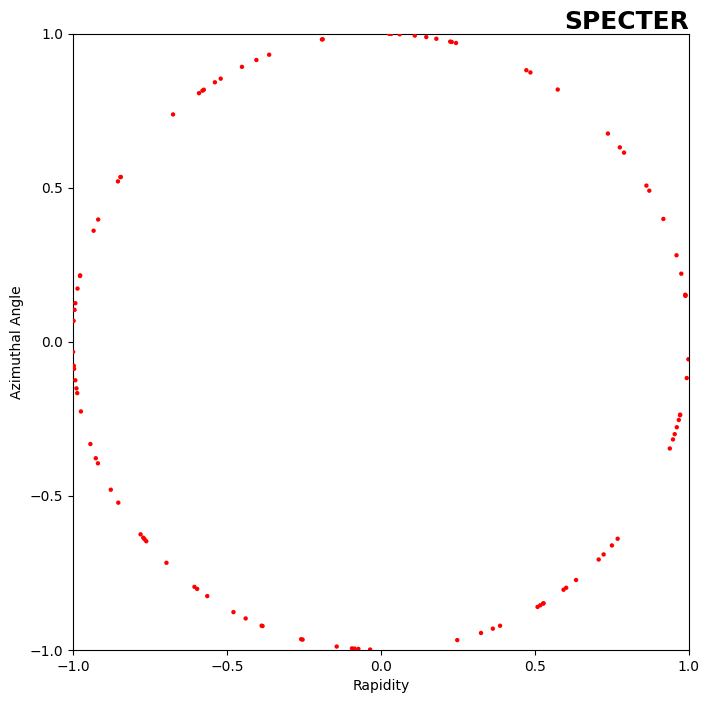

[[0.0000000e+00 9.9999998e-03]
 [7.1006763e-04 1.9999999e-04]
 [1.0282772e-03 1.9999999e-04]
 ...
 [1.9999998e+00 1.9999999e-04]
 [1.9999999e+00 1.9999999e-04]
 [2.0000000e+00 1.9999999e-04]]


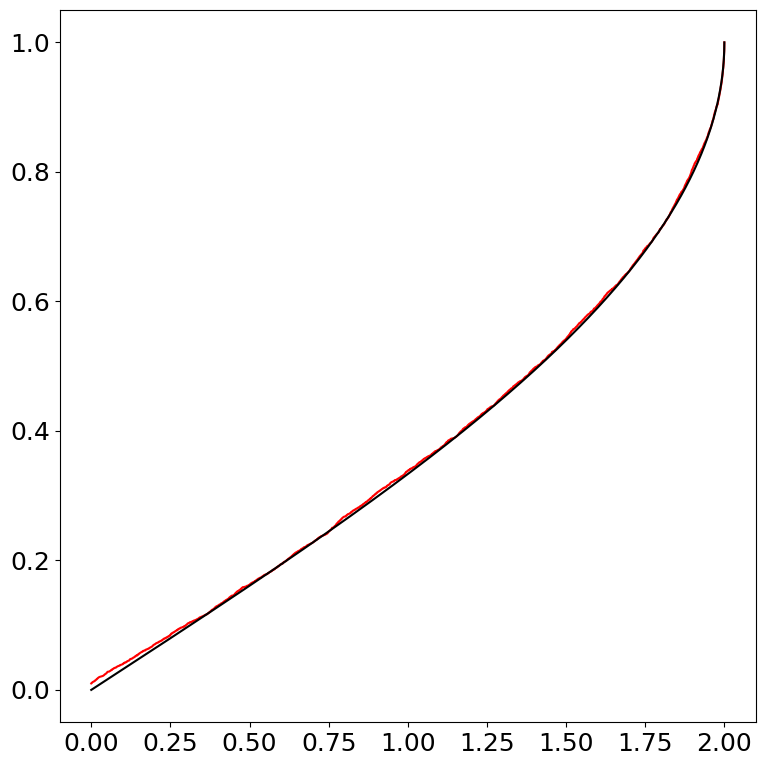

In [ ]:
fig, ax = newplot()
circle = sample_circle({"Radius" : 1.0}, 100, 0)
print(compute_single_event(circle,learning_rate=0.1, finite_difference=False))
print(r_opt(circle))


print
print(closed_form_sEMD(circle,1))

plot_event(circle, 1, ax)

spectral_circle = compute_spectral_representation(circle)
print(spectral_circle)
plt.plot(spectral_circle[:,0], np.cumsum(spectral_circle[:,1]))
plt.plot(spectral_circle[:,0], 2 * 1 *  np.arcsin(spectral_circle[:,0] / 2) / np.pi)

In [ ]:
event_1 = np.array(((0.5, 0, 0), (0.5, 0, 1)))
event_2 = np.array(((0.5, 0, 0), (0.5, 0, 2)))

spectral_1 = compute_spectral_representation(event_1)
spectral_2 = compute_spectral_representation(event_2)

print(spectral_1)
print(spectral_2)

print(ds2_events1_spectral2(event_1, spectral_2))

[[0.  0.5]
 [1.  0.5]]
[[0.  0.5]
 [2.  0.5]]
0.5


In [ ]:


sEMDs, shape_events, losses = compute_single_event(dataset[0])

# # precompute
# with jax.profiler.trace("/tmp/jax-trace-123", create_perfetto_link=True):
#     sEMDs, shape_events, losses = compute_events(dataset[:50], 0.001, 150, finite_difference=False)


N_events = dataset.shape[0]
batch_size = 100
epochs = 50

sEMDs = np.zeros((N_events,))
shape_events = {"Radius" : np.zeros((N_events,))}
losses = np.zeros((epochs, N_events))
for (i, start) in (enumerate(range(0 , N_events, batch_size))):

    print("Batch", i, "of", N_events // batch_size)
    sEMDs[start:start+batch_size], r, losses[:,start:start+batch_size] = compute_events(dataset[start:start+batch_size], 0.005, epochs, N_sample = 350, finite_difference=True)
    shape_events["Radius"][start:start+batch_size] = r["Radius"]


# filename = f"{this_study}_sEMDs.npy"
# save_dir = os.path.join(this_dir, filename)
# np.save(save_dir, sEMDs)

# filename = f"{this_study}_params.npy"
# save_dir = os.path.join(this_dir, filename)
# np.save(save_dir, shape_events["Radius"])

# # plot the average loss per epoch
# plt.plot(np.mean(losses, axis = -1))
# plt.yscale("log")

100%|██████████| 150/150 [00:05<00:00, 29.63it/s]


Batch 0 of 100
(100, 2776, 2) (100, 75, 3)


100%|██████████| 50/50 [03:27<00:00,  4.16s/it]


Batch 1 of 100
(100, 2776, 2) (100, 75, 3)


 72%|███████▏  | 36/50 [02:42<01:03,  4.52s/it]


KeyboardInterrupt: 

[0.0119271  0.00889447 0.00455209 ... 0.0036124  0.00561976 0.00852723] [0.08135022 0.00975383 0.00404478 ... 0.00428824 0.00514621 0.00835496]


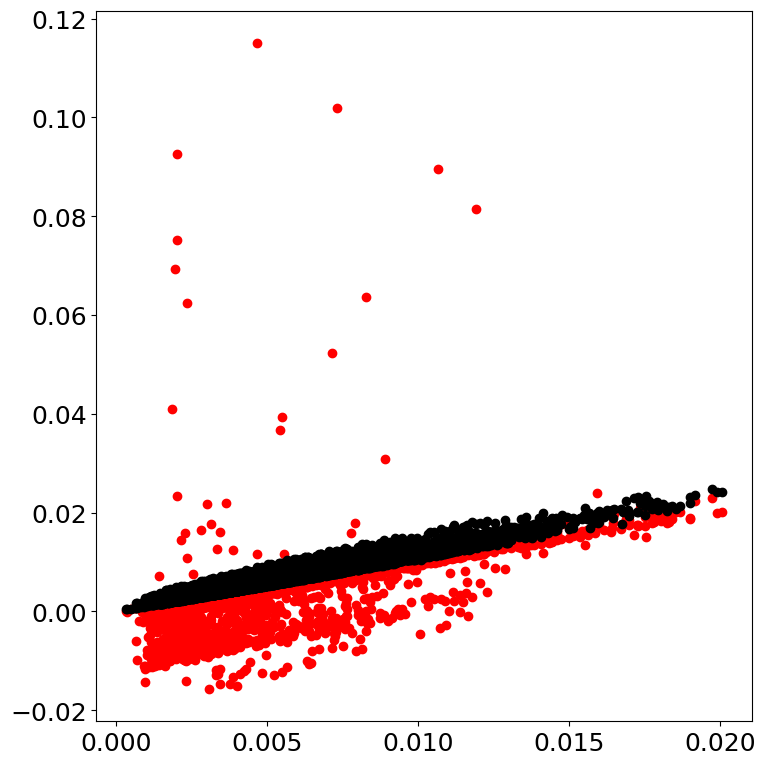

In [ ]:
sEMDs_closed_r = vmapped_closed_form_sEMD(dataset, shape_events["Radius"])

print(sEMDs, sEMDs_closed_r)
plt.scatter(sEMDs, sEMDs_closed_r)
plt.scatter(sEMDs, r2)

(10000,)
[0.1        0.08550589 0.11807662 ... 0.08923623 0.07645795 0.0782597 ]


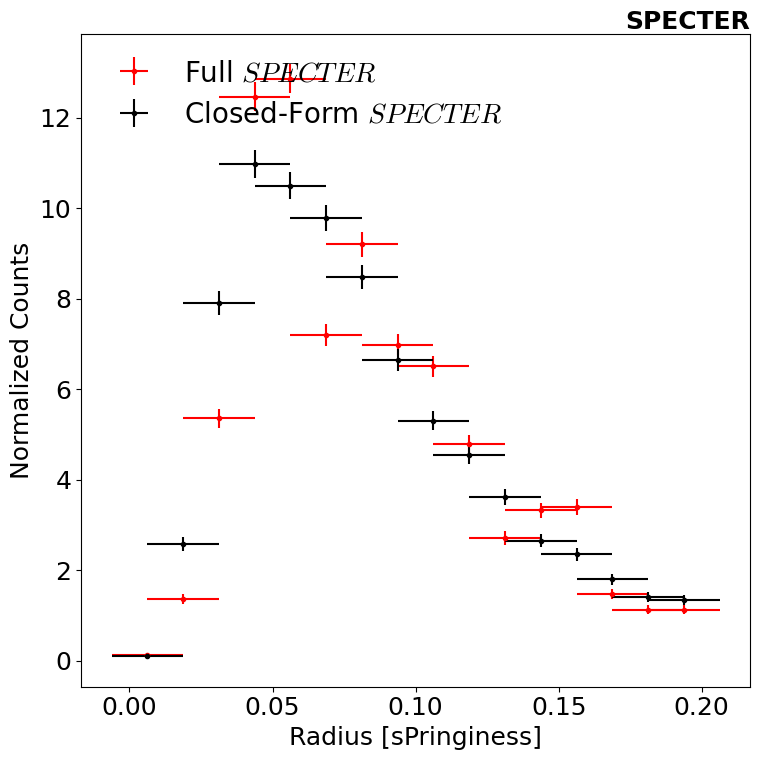

In [ ]:
print(sEMDs.shape)
print(shape_events["Radius"])

# Function to take a list of points and create a histogram of points with sqrt(N) errors, normalized to unit area
def hist_with_errors(ax, points, bins, range, weights = None, **kwargs):

    if weights is None:
        weights = np.ones_like(points)

    hist, bin_edges = np.histogram(points, bins = bins, range = range, weights = weights)
    errs2 = np.histogram(points, bins = bins, range = range, weights = weights**2)[0] + 1

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = (bin_edges[1:] - bin_edges[:-1])

    hist_tot = np.sum(hist * bin_widths)
    hist = hist / hist_tot
    errs2 = errs2 / (hist_tot**2)

    ax.errorbar(bin_centers, hist, np.sqrt(errs2), xerr = bin_widths, fmt = ".", **kwargs)



fig, ax = newplot()
hist_with_errors(ax, shape_events["Radius"], bins = 16, range = (0, 0.2), label = R"Full $SPECTER$")
hist_with_errors(ax, closed_form_r, bins = 16, range = (0, 0.2), label = R"Closed-Form $SPECTER$")

# plt.hist(shape_events["Radius"], bins = 16, range = (0, 1.6), density = True)
plt.xlabel("Radius [sPringiness]")
plt.ylabel("Normalized Counts")
plt.legend(frameon = False, loc = "upper left")



# Closed Form Expressions

In [ ]:
# closed_form_sEMDs = closed_form_2_spronginess(dataset, levels = 150)
# print(closed_form_sEMDs)


# filename = f"{this_study}_closed_form_sEMDs.npy"
# save_dir = os.path.join(this_dir, filename)
# np.save(save_dir, closed_form_sEMDs)

# SHAPER

In [7]:
# SHAPER
from pyshaper.CommonObservables import buildCommmonObservables
from pyshaper.Observables import Observable
from pyshaper.Shaper import Shaper

# Necessary GPU nonsense
import torch 

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 


# Generate new events

R = 1.0
N = 180
angles = np.linspace(0, np.pi, N)
energies = np.linspace(0, 1, N)

# events = []
# for i in range(dataset.shape[0]):

#     event = dataset[i]

#     zs = event[:,0]
#     points = event[:,1:3]

#     events.append((points, zs))


# EMDs

commonObservables, pointers = buildCommmonObservables(N = 3, beta = 2, R = R, device = device)
_2subjettiness = commonObservables["1-Ringiness"]

# Default value
# _2subjettiness.params["Radius1"] = _2subjettiness.params.pop("Radius")
# _2subjettiness.params["Radius1"].default_value = torch.tensor([.5,])
_2subjettiness.freeze("Points", torch.zeros(1, 2))


def ring_sampler(N, param_dict):

        centers = param_dict["Points"].params
        num = param_dict["Points"].N
        radii = param_dict["Radius1"].params
        weights = param_dict["Weights"].params

        phi = 2 * np.pi * torch.rand(num, N).to(device)
        points = torch.stack([torch.cos(phi), torch.sin(phi)], axis=1) * radii[:, None, None] + centers[:, :, None]
        points = torch.cat([point for point in points], dim=1)

        # Concatenate and reweight
        e = points.T
        z = torch.cat([weights[i] * torch.ones((N,), device=device) / N for i in range(num)], dim=0)
        return (e, z)


# _2subjettiness.sampler = ring_sampler

# Collect our observables in one dictionary
observables = {}
observables["1-Ringiness"] = _2subjettiness



# Initialize SHAPER
shaper = Shaper(observables, device)
shaper.to(device)


EMDs = []
params = []


dataset_emds, dataset_params = shaper.calculate(dataset, epochs = 500, verbose=True, lr = 0.01, N = 50, scaling = 0.9, epsilon = 0.001, early_stopping= 25)
for j in range(dataset.shape[0]):
    e = dataset_params["1-Ringiness"][j]["EMD"]
    EMDs.append(e)
    params.append(dataset_params["1-Ringiness"][j]["Radius"])


EMDs = np.array(EMDs)
params = np.array(params)


plt.hist(params)
print(np.mean(params))

filename = f"{this_study}_shaper_EMDs.npy"
save_dir = os.path.join(this_dir, filename)
np.save(save_dir, EMDs)

filename = f"{this_study}_shaper_params.npy"
save_dir = os.path.join(this_dir, filename)
np.save(save_dir, params)

# Plots

FileNotFoundError: [Errno 2] No such file or directory: 'cmsopendata_closed_form_sEMDs.npy'

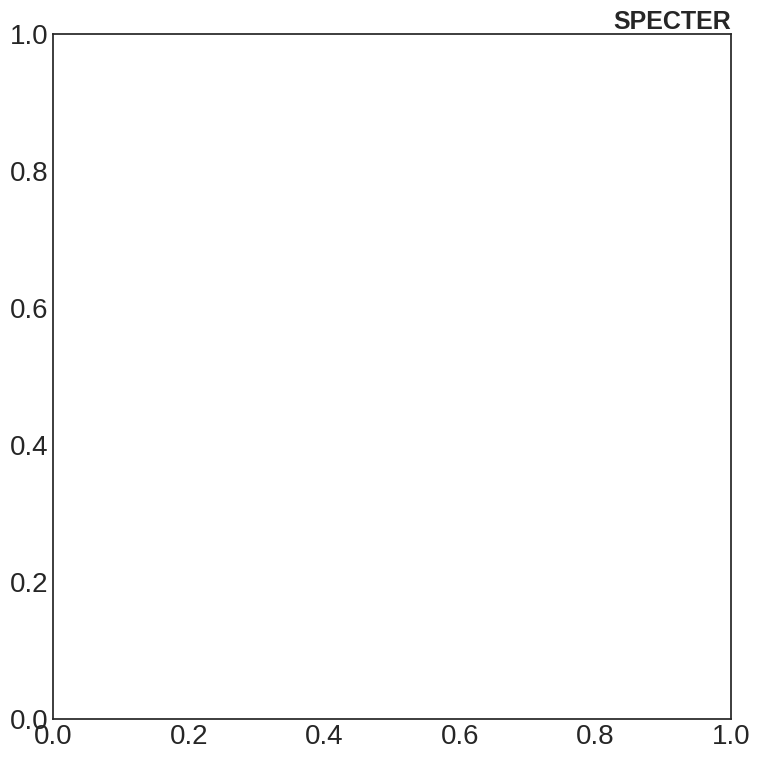

In [ ]:
fig, ax = newplot()

# Load numpy data
sEMDs = np.load(os.path.join(this_dir, f"{this_study}_sEMDs.npy"))
closed_form_sEMDs = np.load(os.path.join(this_dir, f"{this_study}_closed_form_sEMDs.npy"))
EMDs = np.load(os.path.join(this_dir, f"{this_study}_shaper_EMDs.npy"))


plt.scatter(2 * EMDs**2, closed_form_sEMDs, color = "red", alpha = 0.5)
plt.scatter(2 * EMDs**2,  sEMDs, color = "blue", alpha = 0.5)



plt.xscale("log")
plt.yscale("log")
plt.xlabel("2-Subjettiness ($SHAPER$)")
plt.ylabel("2-Sprubjetiness ($SPECTER$)")

# Dashed line at y = x
x = np.linspace(0, np.max(sEMDs), 100)
plt.plot(x, x, linestyle = "--", color = "black")

# print the MSE in the top left
mse = np.mean((np.maximum(sEMDs, 0) - closed_form_sEMDs)**2)
plt.text(0.05, 0.95, "MSE: %.3e\n1000 Events" % mse, transform=ax.transAxes, fontsize=14,)

# print the percentage of events that differ by more than temp1%
diff = (sEMDs - (2 * EMDs**2)) / (2 * EMDs**2)
print(np.sum(diff > 0.10))
# plt.scatter(np.maximum(sEMDs, 0)[diff > 0.10], closed_form_sEMDs[diff > 0.10])

# ax.set_aspect('equal')

In [ ]:
# Plot a histogram of the differences
fig, ax = newplot()
plt.hist(diff, bins = 50 )

# plt.xscale("log")
plt.yscale("log")

plt.xlabel("Fractional Error")
